In [137]:
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from minisom import MiniSom
from shapely.geometry import Point
import geopandas as gpd
from region_details import get_region_details



Needed input files:
- EFAS daily/6 hourly dischgarge data, within the basin from pre-process-watershed. Pre-processing can be integrated here.
- Precipitation data
- MSLP/Z500 circulation data

CONTROL PARAMETERS
- Definition of hazard: single grid point discharge, maximum-basin discharge, economic (to be integrated)
- Criteria for events selection for clustering. (an option could also be to only select top 10 events here, and then then do the clustering sesaonal forecasts only.)

OUTPUT:
- Fig 1: Timeseries discharge and year with largest event
- Fig 2: Mean seasonal cycle discharge and extrems, as given by 90th percentile interannulal variability (~1 in 10 years event), and maximum value
- Fig 3: Spatial map of discharge during largest event
- Fig 4: Determining the most correlated precip accumulation length and lag (to be done), and the strength of the correlation. High -> single storm events. Weak -> events have a compound nature. 
- Fig 5: Return period curve

QUESTIONS:
- Meteorological forcing could develop over multiple days. How to define the relevant meteorological pattern?
- If there is a strong contribution from snow melting, meteorological driving can be weak/varied
- Defining the number of events: depening on the autocorrelation of discharge, percentile-defined threshold will lead to a different number of events
- How to treat single forcing, vs compound events.
- Averaging of precipitation in watershed really slow! Consider saving mask and multiply with cdo or within numpy. 


In [138]:
# SORT OF USER CONFIGURATION
EFASDIR_HIST="/home/zappa/work_big/EFAS"

# Name Pattern of EFAS data, * reflects different years
watershed='timis'
tres='day'
#
# path of efas data masked for watershed
wshed_fname=f"{EFASDIR_HIST}/postpro/{tres}/watersheds/efas_{watershed}_masked.nc"  # from preprocessed file

# path of maximum discharge in watershed
wshed_dismax_fname=os.path.dirname(wshed_fname)+f"/basinmax/efas_{watershed}.nc"

# directory of HydroBasins shapefile
shape_dir="/work_big/users/zappa/TRANSLATE/HydroBasins/hybas_lake_eu_lev01-12_v1c/"

# path to directory with figures
figdir=f"/home/zappa/work_big/TRANSLATE/figures/efas_historical/{watershed}/"
os.makedirs(figdir, exist_ok=True)

# variable name in EFAS file
if tres=='day':
    disname='dis24'
elif tres=='6h':
    disname='dis06'

# starting and last year to be analysed (EFAS historical)
sy=1992
ly=2023

# region details
winfo=get_region_details(watershed)
tlon=winfo['tlon']
tlat=winfo['tlat']
tlabel=winfo['tlabel']
hblevel=winfo['shape_file_level']
bbox=winfo['bounding_box'] # lonS, latW, lonN, latE
#atmbox=winfo['era_box'] 

# watershed central point
wspoint = Point(tlon, tlat)

# temporary output EFAS timeseries at single point
fname_gp=f"{EFASDIR_HIST}/postpro/{tres}/single_gp/efas_{watershed}_{tlabel}_{tres}.nc"

# FLAGS
plot2d_day=False
ReadExisting=True  # allows faster execution if True. If False, the EFAS data is read from the netcdf files
HazardDef="wmax"   # gridpoint (gp), watershed max (wmax), economic (eco) 


# Reading watershed

<Axes: >

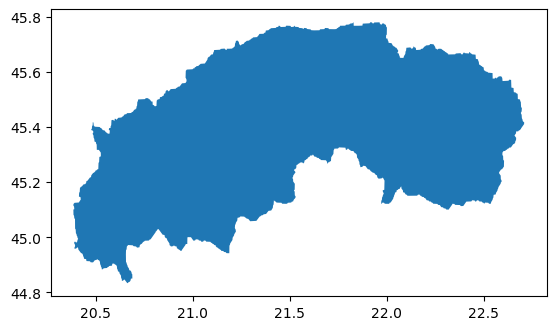

In [139]:
# read watershed shapefiles
def read_watershed_shapefiles(shape_dir, level, wspoint):
    """
    Read watershed shapefiles and extract the shapefile entry that contains a specific point.

    Parameters:
    shape_dir (str): The directory where the shapefiles are located.
    level (str): The level of the shapefiles to read.
    wspoint (Point): The point to analyze.

    Returns:
    GeoDataFrame: A GeoDataFrame containing the shapefile entry that contains the point.
    """
    # Construct the shapefile path
    shapef_path = os.path.join(shape_dir, f"hybas_lake_eu_lev{level}_v1c.shp")

    # Read the shapefile
    shape_gdf = gpd.read_file(shapef_path)

    # Find the shapefile entries that contain the point
    contains_point = shape_gdf['geometry'].contains(wspoint)

    # Extract the shapefile entry that contains the point
    shape_basin_gdf = shape_gdf[contains_point]

    return shape_basin_gdf


def xarray_in_shapefile(xds,varname,latname,lonname,shapef,operation):
    
    # compute average precipitation (ds_emo) for grid points within shape_basin_gdf
    df = xds[varname].to_dataframe()
    lats = df.index.get_level_values(latname)
    lons = df.index.get_level_values(lonname)
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(lons,lats),crs='EPSG:4326')

    # created join dataframe between data and shapefile
    gdf_joined = gpd.sjoin(gdf, shapef, predicate='within')

     # Group by time and region, and sum the values
    if operation=='mean':
        results = gdf_joined.groupby(['time', 'index_right'])[varname].mean()
    elif operation=='sum':
        results = gdf_joined.groupby(['time', 'index_right'])[varname].sum()
    elif operation=='max':
        results = gdf_joined.groupby(['time', 'index_right'])[varname].max()

    # Convert the series to a DataFrame and pivot it
    results_df=pd.DataFrame()
    results_df[varname] = results.reset_index().pivot(index='time', columns='index_right', values=varname)
    results_xds=results_df.to_xarray()

    return results_df, results_xds

# read shape file
shape_basin_gdf=read_watershed_shapefiles(shape_dir, hblevel, wspoint)
shape_basin_gdf.plot()


### Read and store watershed data, single grid point

In [140]:
# Read EFAS data for single grid point, and save it to .nc for more rapid access in future executions
# It would make sense to have a function that reads the hazard: either as a single grid point, watershed max, or economic
def read_and_store_time_series(fname_pat, lat, lon, output_file, ReadExisting):
        
    """
    Read time series data from a specified grid point and store it on disk.
    
    Parameters:
    fname_pat (str or list of str): File path pattern or list of file paths.
    lat_index (int): Index of the latitude grid point.
    lon_index (int): Index of the longitude grid point.
    output_file (str): Output file name to store the time series data (default: 'time_series_data.nc').
    check_existing (bool): Whether to check if the output file already exists (default: True).
    """
    # Check if the output file already exists
    if ReadExisting and os.path.exists(output_file):
        # If the output file exists, read it straight away
        time_series = xr.open_dataset(output_file)
    else:
        # If the output file does not exist, proceed with extracting data from the dataset
        # Open the multi-file dataset
        dataset = xr.open_mfdataset(fname_pat, combine='by_coords')

        # Extract time series data for the specified grid point
        time_series = dataset.sel(lat=lat,lon=lon,method='nearest')

        # Store the extracted time series data on disk
        time_series.to_netcdf(output_file)
    
    return time_series

# read hazard based on hazard definition
if HazardDef=="gp":
    xds_hazard = read_and_store_time_series(wshed_fname, tlat, tlon, fname_gp, ReadExisting)
elif HazardDef=="wmax":
    # if maximum discharge exists, read it, otherwise compute it
    if os.path.exists(wshed_dismax_fname) and ReadExisting:
        xds_hazard=xr.open_dataset(wshed_dismax_fname)
    else:
        # read EFAS data
        xds=xr.open_mfdataset(wshed_fname,combine='by_coords')
        xds_hazard=xds.max(dim=['lat', 'lon'])

        # save to file
        xds_hazard.to_netcdf(wshed_dismax_fname)

# discharge values (convert to numpy array)
ds_hazard=xds_hazard[disname].values

# Plot example streamflow map in a given day, with watershed contour

In [141]:
# Plot a map for a day associated with Panaro flooding near Modena
# It would be more efficient if we just read the .nc containing the event (sort by year)
if plot2d_day:   
    #
    dataset2d = xr.open_mfdataset(wshed_fname, combine='by_coords')

    # Access variables within the dataset
    time_step = '2013-10-20T00:00:00'  # Example time step
    data2d_day=dataset2d.sel(time=time_step)   

    # Extract longitude, latitude, and variable data
    lon, lat, vv = data2d_day['lon'], data2d_day['lat'], data2d_day[disname]

    # Plot the map
    fig = plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Plot the variable on the map
    plt.pcolormesh(lon, lat, vv, transform=ccrs.PlateCarree(), cmap='viridis')
    plt.xlim(bbox[1], bbox[3])  # Set longitude range
    plt.ylim(bbox[0], bbox[2])  # Set latitude range

    # Add coastlines, gridlines, and title
    ax.coastlines()
    ax.gridlines()
    plt.title(f'Map for {time_step}')
    plt.colorbar(label='discharge')

    # add x and y tick labels
  
    # plot the watershed
    shape_basin_gdf.plot(ax=ax, color='none', edgecolor='red',transform=ccrs.PlateCarree())
    
    plt.show()

# Look at time series of streamflow

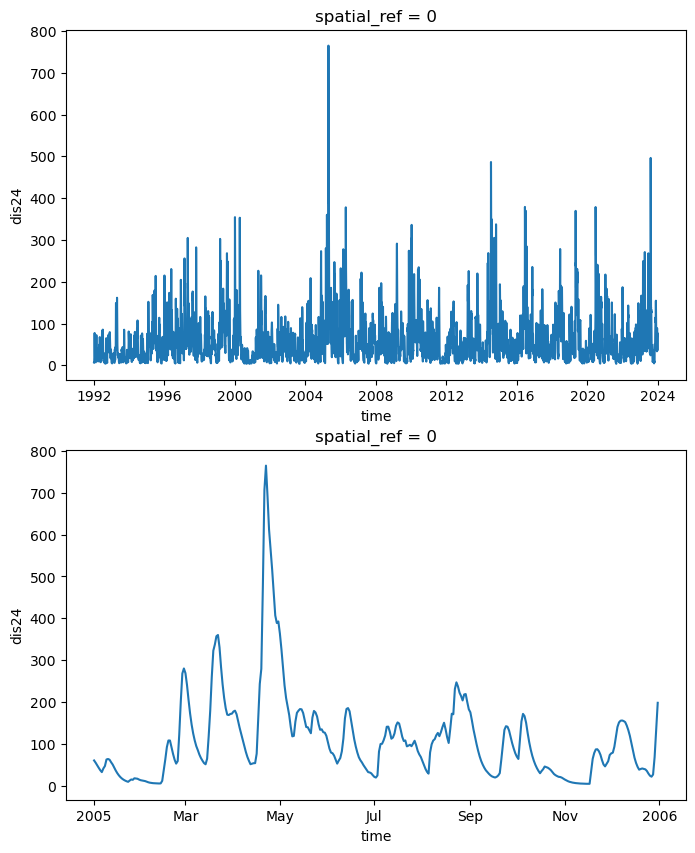

In [142]:

# plot timeseries using xarray 
fig,axs=plt.subplots(2,1,figsize=(8,10))
time_start_plot="1992-01-01"
time_end_plot="2023-12-31"
xds_hazard[disname].sel(time=slice(time_start_plot,time_end_plot)).plot(ax=axs[0])

# select year with maximum discharge
max_year=xds_hazard[disname].idxmax(dim='time').values
max_year = max_year.astype('datetime64[Y]').item().year

# set time_start_plot
time_start_plot=f"{max_year}-01-01"
time_end_plot=f"{max_year}-12-31"
xds_hazard[disname].sel(time=slice(time_start_plot,time_end_plot)).plot(ax=axs[1])


### Mean seasonality analyses

In [143]:
# this is not working, yet
def circular_rolling(da, window_size):
    # Append the start of the DataArray to the end to create a circular buffer
    circular_data = np.concatenate([da, da[:window_size]])

    # Create a new DataArray with the circular buffer
    circular_da = xr.DataArray(circular_data, dims=da.dims, coords=da.coords)

    # Apply the rolling operation
    result = circular_da.rolling({da.dims[0]: window_size}, center=True).mean()

    # Slice off the extra values at the end
    result = result[:len(da)]

    return result


In [144]:

# Compute statistics of seasonal cycle and save to file
# check if output exists
window_size = 45  # Smoothing to highlight mean seasonal cycle
percentile_value=50 # percentile of extremes values within 1 week window across years
stats_clim_fname=f"{EFASDIR_HIST}/postpro/{tres}/watersheds/stats/efas_{watershed}_seasonalcycle_win{window_size}_pctx{percentile_value}.nc"
if os.path.exists(stats_clim_fname) and ReadExisting:
    xds_stats_clim=xr.open_dataset(stats_clim_fname)
    # daily_means=xds_stats_clim['daily_means']
    # smoothed_means=xds_stats_clim['smoothed_means']
    # daily_max=xds_stats_clim['daily_max']
    # smoothed_max=xds_stats_clim['smoothed_max']
    # monthly_max_p=xds_stats_clim['week_max_p']
    # smoothed_week_max=xds_stats_clim['smoothed_week_max']
else:
    # mean seasonality
    daily_means = xds_hazard[disname].groupby('time.dayofyear').mean(dim='time')
    daily_max = xds_hazard[disname].groupby('time.dayofyear').max(dim='time')

    week_max = xds_hazard[disname].resample(time='1W').max(dim='time').chunk({'time': -1})
    week_max_p50 = week_max.groupby('time.week').quantile(q=50 / 100, dim='time')
    week_max_p90 = week_max.groupby('time.week').quantile(q=90 / 100, dim='time')
    week_max_max = week_max.groupby('time.week').max(dim='time')

    monthly_max = xds_hazard[disname].resample(time='1M').max(dim='time').chunk({'time': -1})
    monthly_max_p50 = monthly_max.groupby('time.month').quantile(q=50 / 100, dim='time')
    monthly_max_p90 = monthly_max.groupby('time.month').quantile(q=90 / 100, dim='time')
    monthly_max_max = monthly_max.groupby('time.month').max(dim='time')

    # roolling average
    week_size=int(np.round(window_size/7))
    smoothed_means = daily_means.rolling(dayofyear=window_size, center=True).mean()
    smoothed_max = daily_max.rolling(dayofyear=window_size, center=True).mean()

    # save to file
    xds_stats_clim=xr.Dataset()
    xds_stats_clim['daily_means']=daily_means
    xds_stats_clim['smoothed_means']=smoothed_means
    xds_stats_clim['daily_max']=daily_max
    xds_stats_clim['smoothed_max']=smoothed_max
    xds_stats_clim['monthly_max']=monthly_max
    xds_stats_clim['week_max_p50']=week_max_p50
    xds_stats_clim['week_max_p90']=week_max_p90
    xds_stats_clim['week_max_max']=week_max_max
    xds_stats_clim['monthly_max_p50']=monthly_max_p50
    xds_stats_clim['monthly_max_p90']=monthly_max_p90
    xds_stats_clim['monthly_max_max']=monthly_max_max
    
    # remove file if exists
    if os.path.exists(stats_clim_fname):
        os.remove(stats_clim_fname)
    xds_stats_clim.to_netcdf(stats_clim_fname)

Text(0, 0.5, 'Discharge (m3/s)')

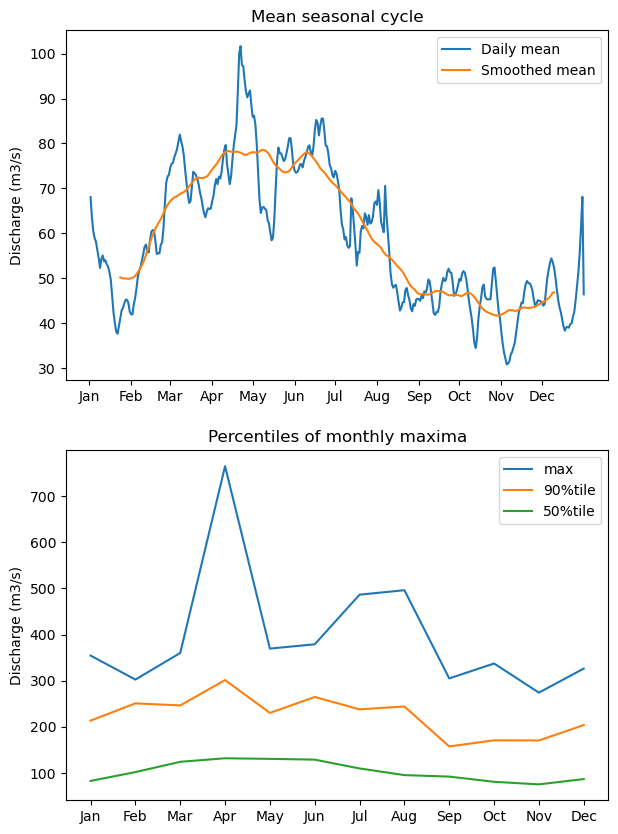

In [145]:
# plot stats

# day corresponding to first day of each month
# length of months in days
month_lengths = np.array([31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
# accumulate
month_starts = np.cumsum(month_lengths) - month_lengths

plt.figure
fig, axs = plt.subplots(2, 1, figsize=(7, 10))  # 2 rows, 1 column
xds_stats_clim['daily_means'].plot(ax=axs[0])
xds_stats_clim['smoothed_means'].plot(ax=axs[0])
axs[0].set_title('Mean seasonal cycle')
axs[0].set_xticks(month_starts)
axs[0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axs[0].legend(['Daily mean', 'Smoothed mean'])
axs[0].set_xlabel('')
axs[0].set_ylabel('Discharge (m3/s)')
# remove day of year from plot

# tx=1
# xds_stats_clim['week_max_p50'].plot(ax=axs[tx])
# xds_stats_clim['week_max_p90'].plot(ax=axs[tx])
# xds_stats_clim['week_max_max'].plot(ax=axs[tx])
# axs[tx].set_title(f'Percentiles of week maxima')
# #axs[tx].set_xticks(np.arange(1, 13, 1))
# #axs[tx].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
# axs[tx].legend(['50#tile', '90%tile', 'max'])
# axs[tx].set_xlabel('')
# axs[tx].set_ylabel('Discharge (m3/s)')

tx=1
xds_stats_clim['monthly_max_max'].plot(ax=axs[tx])
xds_stats_clim['monthly_max_p90'].plot(ax=axs[tx])
xds_stats_clim['monthly_max_p50'].plot(ax=axs[tx])

axs[tx].set_title(f'Percentiles of monthly maxima')
axs[tx].set_xticks(np.arange(1, 13, 1))
axs[tx].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axs[tx].legend(['max','90%tile', '50%tile'])
axs[tx].set_xlabel('')
axs[tx].set_ylabel('Discharge (m3/s)')
# legend


### Identify extreme events (single grid point)

In [146]:
def find_events(xdata, prcth, gap=0):
    # xdata: xarray of values
    # data: 1D array of values
    # threshold: threshold value for event detection
    # gap: minimum number of consecutive values below the threshold to consider as a new event

    data=xdata.values

    # define threshold
    threshold=np.percentile(data, prcth)

    # initialize variables
    events = []        # output list of events
    event_start = None # start index of an event
    event_values = []  # List to store values within each event
    in_event=False

    ierror=0

    # Loop through the data array
    for i, value in enumerate(data):
        if value > threshold:
            if not in_event:
                # Start of a new event
                in_event=True
                #event_start = i
                event_start=xdata['time'].values[i]
            event_values.append(value)
            #print(event_values)
        else:
            # End of an event
            if np.all(data[i:i+gap]<threshold) and in_event: 
                # time of maximum value of event
                event_max_time=np.timedelta64(np.argmax(event_values), 'D')

                # maximum discharge
                event_max=np.max(event_values)

                # length of event
                event_length=len(event_values)

                events.append((event_start+event_max_time, event_max, event_start, event_length, event_values))  # Append the event start and end indices                

                #event_start = None  # Reset event start index
                #event_length = None
                #event_max = None
                #event_max_time = None                
                event_values = []  # Reset event_values    
                in_event=False

            elif np.sum(data[i:i+gap]>=threshold) and in_event:
                event_values.append(value) 

    print(ierror)

    # Convert events to a pandas DataFrame
    df_events = pd.DataFrame(events)
    df_events.columns = ['max_time', 'max_value', 'start_time', 'n_days', 'values']

    # order based on max_value
    df_events.sort_values(by='max_value', ascending=False, inplace=True)

    #event_length=df_events[2].apply(len)
    #event_max=df_events[2].apply(max)
    
    return df_events, threshold


0
Number of events: 71
Discharge threshold for events:  169.99720458984356
     max_time   max_value start_time  n_days  \
23 2005-04-22  764.797852 2005-04-18      29   
70 2023-08-07  496.103882 2023-08-07       6   
48 2014-07-14  486.394897 2014-07-13      28   
53 2016-06-17  378.916260 2016-06-08      29   
61 2020-06-21  378.659180 2020-06-19      12   
..        ...         ...        ...     ...   
24 2005-05-23  178.617188 2005-05-23       2   
57 2018-05-20  178.159546 2018-05-20       2   
8  1997-08-07  176.599365 1997-08-01       9   
3  1996-04-09  173.474609 1996-04-09       1   
27 2005-10-05  171.607422 2005-10-05       1   

                                               values  
23  [243.11621, 279.3247, 476.52954, 706.5337, 764...  
70  [496.10388, 404.42017, 387.38232, 317.5547, 22...  
48  [466.23486, 486.3949, 460.8352, 399.1128, 300....  
53  [174.53625, 186.97314, 184.13965, 172.38318, 1...  
61  [258.5161, 349.73486, 378.65918, 370.6277, 310...  
..          

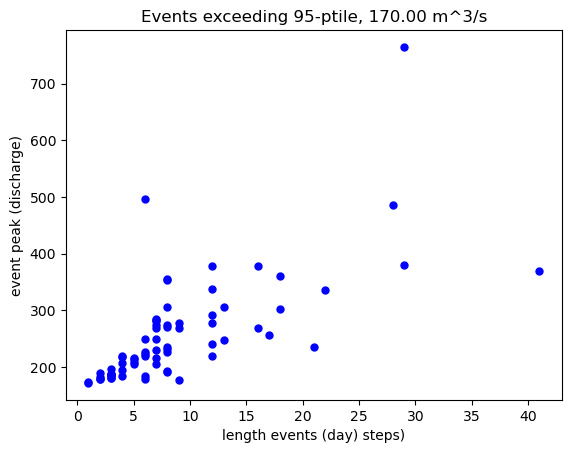

In [147]:

# minimum number of time steps below threshold between independent events. Otherwise it's the same event
if tres=='day':
    steps_independent_event=6
elif tres=='6h':
    steps_independent_event=3

# threshold precentile for event definition (across all timesteps)
prcth=95
df_events,dis_threshold=find_events(xds_hazard['dis24'],prcth,steps_independent_event)

plt.figure
plt.plot(df_events['n_days'],df_events['max_value'],marker='o', linestyle='None', markersize=5, color='blue')
plt.xlabel(f'length events ({tres}) steps)')
plt.ylabel('event peak (discharge)')
plt.title(f'Events exceeding {prcth}-ptile, {dis_threshold:,.2f} m^3/s')

# print number of events
print(f"Number of events: {len(df_events)}")
print('Discharge threshold for events: ',dis_threshold)
print(df_events)


### Read ERA data

In [148]:
ERA5dir='/home/zappa/work/ERA5/hourly/'
data_files = {
    ('mean_sea_level_pressure', 'MSL','sfc'),
    ('surface_pressure', 'SP','sfc'),
    ('geopotential','Z','500hPa')
}

years = range(sy, ly+1)

# Loop over each file and variable name
vdata=xr.Dataset()
for variable, variable_name, level_name in data_files:
    if tres=='day':
        erasubdir='day'
        ext=f'day_full_{level_name}_55-55_70_-50_10_55'
        file_paths = f"{ERA5dir}/{variable}/{erasubdir}/ERA5_{variable}_{ext}.nc"
        ds1 = xr.open_dataset(file_paths)
        ds1=ds1.sel(time=slice(str(sy),str(ly)))
    elif tres=='6h':
        erasubdir='6hrs'
        ext=f'6hrs_full_{level_name}_{{year}}_70_-50_10_55'
        file_paths = [f"{ERA5dir}/{variable}/{erasubdir}/ERA5_{variable}_{ext}.nc".format(year=year) for year in years]
        ds1 = xr.open_mfdataset(file_paths,combine='by_coords')

    # convert MSL to hPa
    if variable_name=='MSL':
        ds1['MSL']=ds1['MSL']/100

    vdata=vdata.assign(**{variable_name: ds1[variable_name]})
    del ds1

### Read EMO data and compute area averaged precipitation

In [149]:
import glob

## for each file in EMO1 ending in .nc, read it and save it to a new file with the same name in the new directory
EMO1dir='/home/zappa/work_big/EMO1'

# file name of area-averaged precipitation
precip_basin_fname=f"{EMO1dir}/pr/{watershed}/precip_{watershed}.nc"

# create directory if doesn't exist (considering moving this to the top / and some other directory)
os.makedirs(os.path.dirname(precip_basin_fname), exist_ok=True)

# if exist precip_basin_fname, read it, otherwise compute it
ReadExisting1=True # always read, because rather slow.
if os.path.exists(precip_basin_fname) and ReadExisting1:
    xds_pr_ws_ms=xr.open_dataset(precip_basin_fname)
    print('already processed')
else:
    file_list=glob.glob(f"{EMO1dir}/pr/*.nc")
    print(file_list)        
    xds_emo=xr.open_mfdataset(file_list)
    bbox_lon=slice(bbox[1],bbox[3])
    bbox_lat=slice(bbox[2],bbox[0])
    xds_emo=xds_emo.sel(lon=bbox_lon,lat=bbox_lat)

    ### Average precipitation in watershed
    df_pr_ws,xds_pr_ws=xarray_in_shapefile(xds_emo,'pr','lat','lon',shape_basin_gdf,'mean')

    # convert to totol volume of precip
    sec_in_day=24*3600
    area_m2=shape_basin_gdf['UP_AREA'].values*10**6    # km2 to m2
    xds_pr_ws_ms=xds_pr_ws['pr']/1000/sec_in_day       # convert mm/day to m/s
    xds_pr_ws_ms['volume'] = area_m2*xds_pr_ws_ms      # and then to m^3/s

    # compute 5-day accumulation, starting fro current value and previous 2/5 days
    xds_pr_ws_ms['volume2day']=xds_pr_ws_ms['volume'].rolling(time=2).sum()
    xds_pr_ws_ms['volume3day']=xds_pr_ws_ms['volume'].rolling(time=3).sum()
    xds_pr_ws_ms['volume4day']=xds_pr_ws_ms['volume'].rolling(time=4).sum()
    xds_pr_ws_ms['volume5day']=xds_pr_ws_ms['volume'].rolling(time=5).sum()
    xds_pr_ws_ms['volume10day']=xds_pr_ws_ms['volume'].rolling(time=10).sum()

    xds_pr_ws_ms.to_netcdf(precip_basin_fname, mode='w')


already processed


volume 0 0.09729665403624105
volume -1 0.06555055258268969
volume -2 0.05656148201167004
volume -3 0.04808785384329945
volume -4 0.04086425949119176
volume -5 0.03520063229441143
volume2day 0 0.17550792508312588
volume2day -1 0.09770820216314667
volume2day -2 0.0732619328203046
volume2day -3 0.06278920902130707
volume2day -4 0.0533960500058836
volume2day -5 0.04569503805368192
volume3day 0 0.27339983466288603
volume3day -1 0.16370201942063417
volume3day -2 0.10030611851898347
volume3day -3 0.07780814638568562
volume3day -4 0.06654493386607117
volume3day -5 0.056822321531660065
volume4day 0 0.37459626655470274
volume4day -1 0.25236730734354795
volume4day -2 0.15768747177727657
volume4day -3 0.10173044403608666
volume4day -4 0.08028867015208654
volume4day -5 0.06879146253637464
volume5day 0 0.46674892032228776
volume5day -1 0.34727566154706085
volume5day -2 0.23805524202031597
volume5day -3 0.15296011847233096
volume5day -4 0.1019533964620616
volume5day -5 0.0814686966633762
maximum corr

Text(0.5, 1.0, 'volume5day precipitation vs peak discharge')

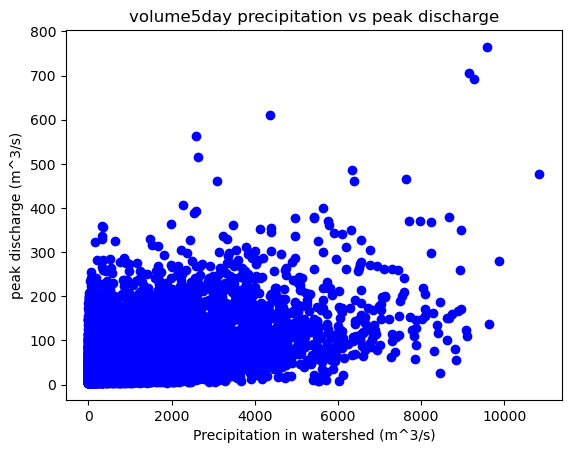

In [150]:
def lag_time_string(time, lag):
    from datetime import datetime, timedelta

    # Convert time_start_plot to a datetime object
    dt = datetime.strptime(time, "%Y-%m-%d")

    # add lag 
    dt += timedelta(days=lag)

    # Convert back to string in the same format
    time = dt.strftime("%Y-%m-%d")
    return time

# function to identify the accumulation of precipitation and lags that maximizes the correlation with the peak discharge
def find_maximum_correlation(xds_precip,xds_hazard,time_start = None, time_end = None, lags=[0]):
    volume_names=('volume', 'volume2day', 'volume3day', 'volume4day', 'volume5day')
    hazard_name='dis24'
    corr_max=0
    vn_max = None
    lag_max = None
    if time_start is not None:
        hazard_ts = xds_hazard[hazard_name].sel(time=slice(time_start, time_end))
    else:
        hazard_ts = xds_hazard[hazard_name]
    for vn in volume_names:
        if time_start is not None:
            precip_ts = xds_precip[vn].sel(time=slice(time_start, time_end))
        else:
            precip_ts = xds_precip[vn]
        for lag in lags:
            # shift precipitation based on lag
            precip_shift=precip_ts.shift(time=lag).fillna(0)
            corr=np.corrcoef(precip_shift.values,hazard_ts.values)[0,1]
            print(vn,lag,corr)
            if corr>corr_max:
                corr_max=corr
                vn_max=vn
                lag_max=lag
    return vn_max, corr_max, lag_max

# scatter of volume precipitation vs peak discharge
time_start_xcorr="1993-01-01"
time_end_xcorr="2020-12-31"
lags=[0, -1, -2, -3, -4, -5]
vol_max, corr_max, lag_max = find_maximum_correlation(xds_pr_ws_ms,xds_hazard,time_start_xcorr,time_end_xcorr,lags)
print('maximum correlation:',vol_max, corr_max, lag_max)

# set lagged start/end for precip
time_start_volume=lag_time_string(time_start_xcorr,lag_max)
time_end_volume=lag_time_string(time_end_xcorr,lag_max)

volume_np = xds_pr_ws_ms[vol_max].sel(time=slice(time_start_volume, time_end_volume)).values
hazard_np = xds_hazard[disname].sel(time=slice(time_start_xcorr, time_end_xcorr)).values

# Now plot using the NumPy arrays
plt.figure()
plt.scatter(volume_np, hazard_np, marker='o', color='blue')
plt.xlabel('Precipitation in watershed (m^3/s)')
plt.ylabel('peak discharge (m^3/s)')
plt.title(f'{vol_max} precipitation vs peak discharge')

# repeat analysis for tail dependence - only keep days with discharge values above a certain threshold


volume 0 0.23739536771307346
volume -1 0.253756393263541
volume -2 0.490487450819108
volume -3 0.5199070084243375
volume -4 -0.03624536993650026
volume -5 -0.1639531514219267
volume2day 0 0.33052006961015234
volume2day -1 0.4687347797231969
volume2day -2 0.6082326094962284
volume2day -3 0.2546790093378688
volume2day -4 -0.12408359904002401
volume2day -5 -0.09692767405354587
volume3day 0 0.4937967572531695
volume3day -1 0.6051386045347595
volume3day -2 0.3983710418287979
volume3day -3 0.14296026290876537
volume3day -4 -0.0964229459066834
volume3day -5 -0.11405787107582795
volume4day 0 0.6165009262041395
volume4day -1 0.4256472520837748
volume4day -2 0.28208787460666257
volume4day -3 0.13856634080125843
volume4day -4 -0.11364634193848151
volume4day -5 -0.13680937222977202
volume5day 0 0.4373806093742399
volume5day -1 0.3056633173949744
volume5day -2 0.2628302819177215
volume5day -3 0.11019778678825769
volume5day -4 -0.13276119958053423
volume5day -5 -0.13124224235197318
maximum correlati

Text(0.5, 1.0, 'volume4day precipitation vs peak discharge tail dependence')

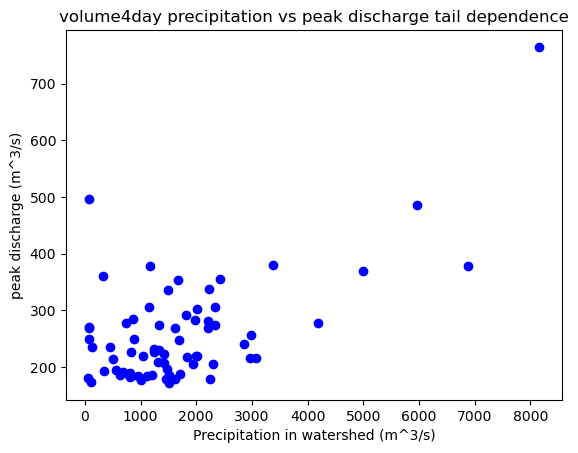

In [151]:
def find_maximum_correlation_events(xds_precip,xds_hazard,events,lags):
    volume_names=('volume', 'volume2day', 'volume3day', 'volume4day', 'volume5day')
    hazard_name='dis24'
    corr_max=0
    vn_max = None
    lag_max = None

    # select events
    hazard_ts=xds_hazard[hazard_name].sel(time=events['max_time'].values,method='nearest')
    for vn in volume_names:      
        for lag in lags:
            # shift precipitation based on lag
            precip_shift=xds_precip[vn].sel(time=(events['max_time']+pd.Timedelta(days=lag)).values,method='nearest')
            corr=np.corrcoef(precip_shift.values,hazard_ts.values)[0,1]
            print(vn,lag,corr)
            if corr>corr_max:
                corr_max=corr
                vn_max=vn
                lag_max=lag
    return vn_max, corr_max, lag_max


lags=[0, -1, -2, -3, -4, -5]
vol_max, corr_max, lag_max = find_maximum_correlation_events(xds_pr_ws_ms,xds_hazard,df_events,lags)
print('maximum correlation:',vol_max, corr_max, lag_max)

xds_hazard_tail=xds_hazard.sel(time=df_events['max_time'].values,method='nearest')
xds_pr_ws_ms_shift=xds_pr_ws_ms.sel(time=(df_events['max_time']+pd.Timedelta(days=lag_max)).values,method='nearest')

plt.figure()
plt.scatter(xds_pr_ws_ms_shift[vol_max].values, xds_hazard_tail[disname].values, marker='o', color='blue')
plt.xlabel('Precipitation in watershed (m^3/s)')
plt.ylabel('peak discharge (m^3/s)')
plt.title(f'{vol_max} precipitation vs peak discharge tail dependence')

### Save SLP maps for the events

In [152]:

# order events based on peak intensity
#df_events_sorted=df_events.sort_values(by=3,axis=0,ascending=False)
#df_events_sorted=df_events
#print(df_events_sorted['max_time'].values)

# extract days in ERA5
#vdata_events=vdata.isel(time=df_events_sorted[0]) # this is ok, fix due to missing leap days in era daily
#tref=xds_hazard['time'].isel(time=df_events_sorted['max_time'].values)
#tref=xds_hazard['time'].sel(time=df_events_sorted['max_time'].values)

# quick fix to bring ERA5 daily means (time 09:00) to the same time as EFAS (time 00:00). This is OK since EFAS reflects trasnport over previous 24 hours
vdata1=vdata
vdata1['time'] = vdata['time'] + pd.Timedelta('15H')

# extract days in ERA5 associated to peak discharge
vdata_events=vdata1.sel(time=df_events['max_time'].values, method='nearest')

/tmp/ipykernel_4044912/539195399.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  vdata1['time'] = vdata['time'] + pd.Timedelta('15H')


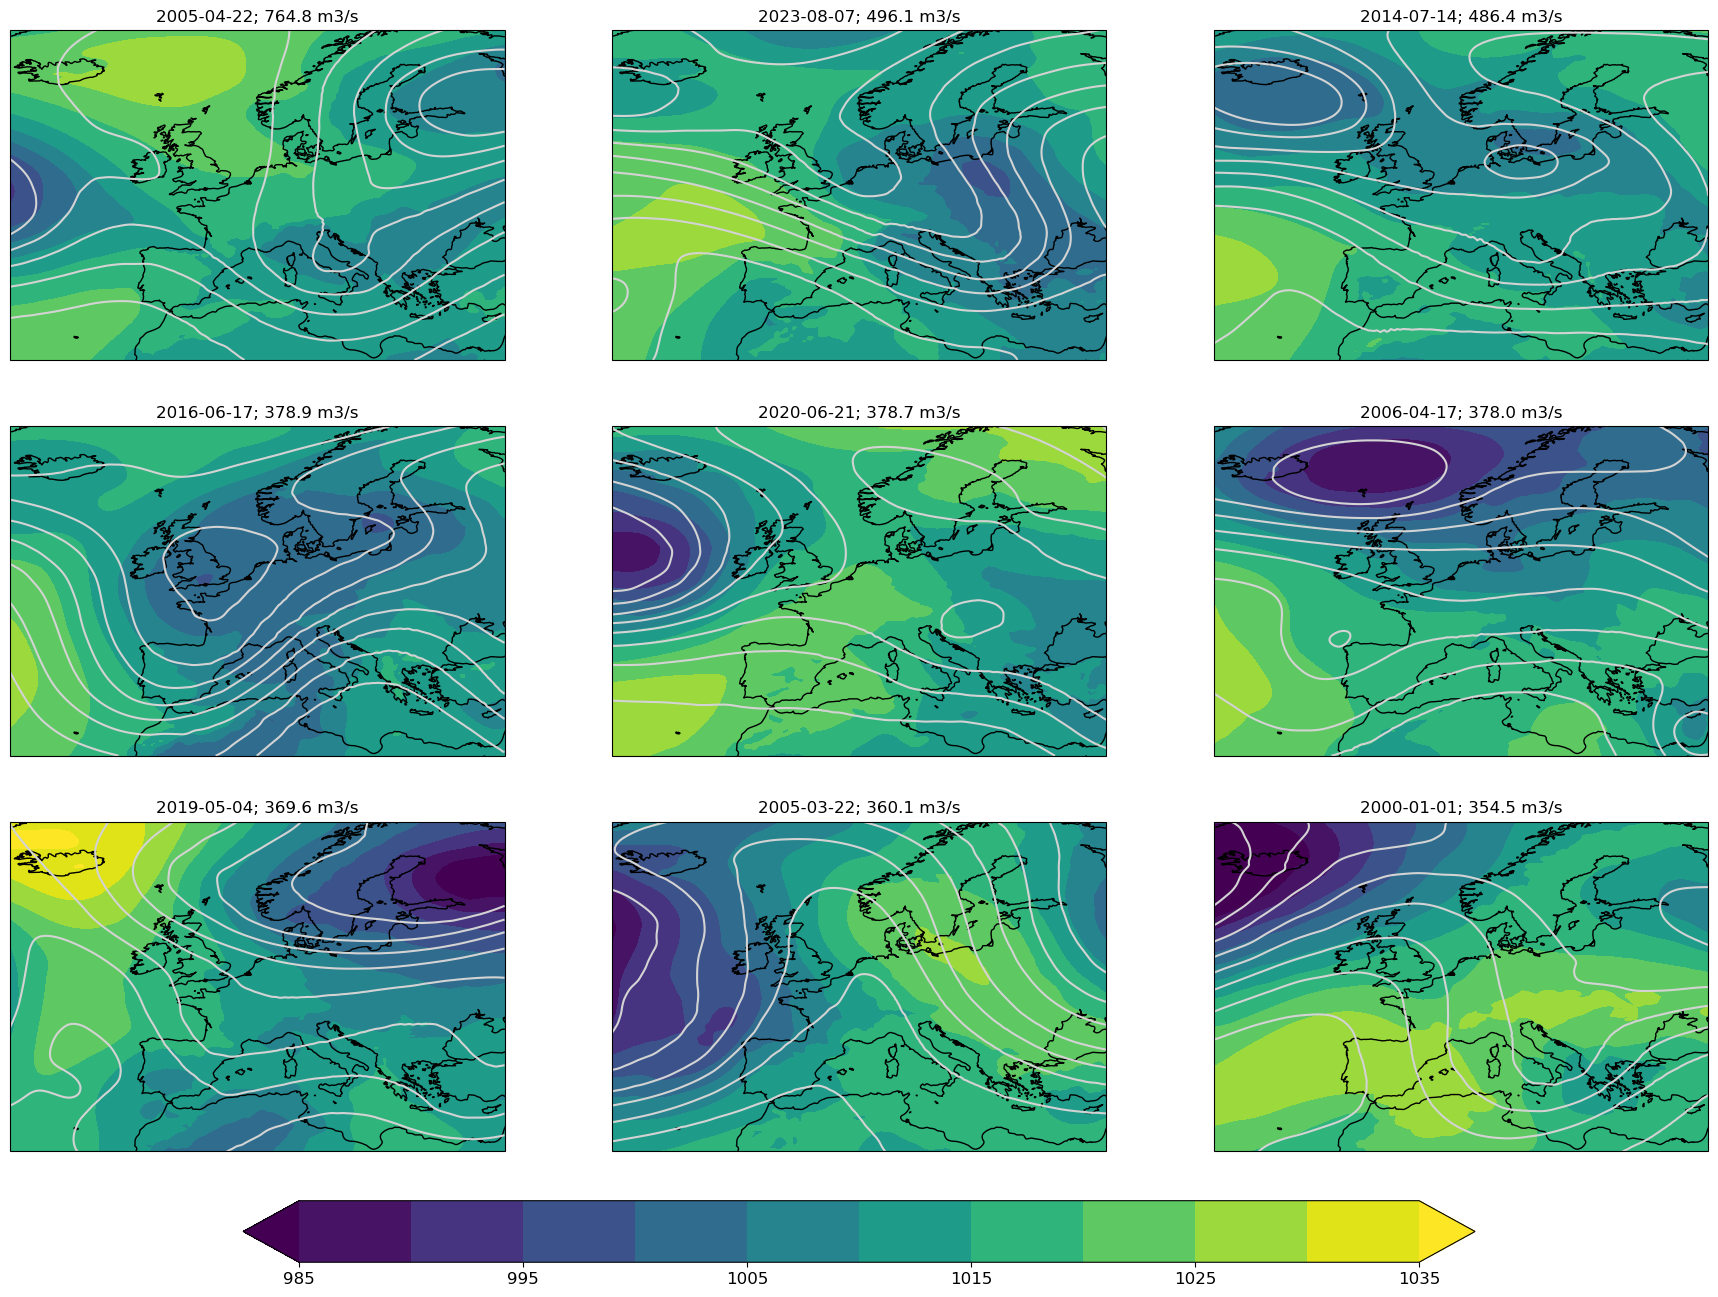

In [153]:

### display map of top 10 events

# plot a subset
max_num_plot=9

# Determine the number of time steps
num_times = max_num_plot

# Calculate the number of rows and columns for the subplot grid
num_rows = int(num_times ** 0.5)
num_cols = (num_times + num_rows - 1) // num_rows

# compute global maximum and minimum values for contour intervals
global_min_MSL = vdata_events.isel(time=slice(0,max_num_plot)).MSL.min(dim=['time', 'lat', 'lon'])
global_max_MSL = vdata_events.isel(time=slice(0,max_num_plot)).MSL.max(dim=['time', 'lat', 'lon'])

# Set uniform contour levels based on global min and max
contour_levels_MSL = np.linspace(985, 1035, num=11)

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(22, 16), subplot_kw={'projection': ccrs.PlateCarree()})

# Flatten the axes array for easier indexing
axes_flat = axes.flatten()

# Loop through each time step and plot in the corresponding subplot
for i, time in enumerate(vdata_events.isel(time=slice(0,max_num_plot)).time):

    row = i // num_cols
    col = i % num_cols

    #data_at_time = vdata_events.sel(time=time,lon=slice(-25,35),lat=slice(65,30))
    data_at_time = vdata_events.sel(time=time,lon=slice(-25,35),lat=slice(70,30))

    # Set contour levels 
    contour_levels_Z500 = np.linspace(data_at_time.Z.min(), data_at_time.Z.max(), num=10)

    # Plot in the corresponding subplot
    ax = axes[row, col]
    ax.set_title(time.dt.strftime('%Y-%m-%d').item()+'; '+df_events['max_value'].values[i].round(1).astype(str)+' m3/s')
    
    #ax.set_extent([-20, 35, 30, 60], crs=ccrs.PlateCarree())  # Set the desired lat/lon range
    im_MSP = ax.contourf(data_at_time['MSL'].lon, data_at_time['MSL'].lat,
                      data_at_time['MSL'], levels=contour_levels_MSL, cmap='viridis', transform=ccrs.PlateCarree(),extend='both')
    im_Z = ax.contour(data_at_time['Z'].lon, data_at_time['Z'].lat,
                      data_at_time['Z'].sel(plev=50000), levels=contour_levels_Z500, colors='lightgrey', transform=ccrs.PlateCarree())

    # Add coastlines using Cartopy
    ax.coastlines()

# Add color bar at the bottom
cbar = fig.colorbar(im_MSP, ax=axes_flat.tolist(), orientation='horizontal', fraction=0.05, pad=0.04)
cbar.ax.xaxis.set_tick_params(labelsize=12)  # Adjust '10' to your desired font size

# Show the plots
plt.show()


In [154]:
def composite_events(vdata, df_events):
    era_events=[]
    for event_start in df_events[0]:
        #print(event_start)
        # Extract data for the event time steps
        era_events_tmp = vdata.isel(time=event_start)
        #print(era_events_tmp.dims)
        # Calculate the average of variable B for the event
        era_events.append(era_events_tmp)
    era_events_concatenated = xr.concat(era_events, dim="event") 
    vdata_clim=vdata.mean(dim='time')
    average_era_events = era_events_concatenated.mean(dim="event")
    average_era_events_anom=average_era_events-vdata_clim

    return average_era_events_anom

## List of variable names you want to extract
#ext='6hrs_full_sfc_{year}_70_-50_10_55'
#data_files = {
#    ('surface_pressure', 'SP')
#}
#years = range(1992, 2024)

# compute composite means... commented: a bit slow become of the anomalies
#comp_mean=composite_events(vdata, df_events)
    

In [155]:
# print(comp_mean)
# # Plot composite mean anomaly the variable on the map
# fig = plt.figure(figsize=(10, 6))
# ax = plt.axes(projection=ccrs.PlateCarree())

# # Plot the data array
# comp_mean['Z'].plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis')

# # Add coastlines and gridlines
# ax.coastlines()
# #ax.gridlines()

# # Show the plot
# plt.show()

In [156]:
from collections import Counter

def train_som(data, num_neurons_x=2, num_neurons_y=3, num_epochs=10000):
    # Create a self-organizing map
    som = MiniSom(num_neurons_x, num_neurons_y, data.shape[1], sigma=0.6, learning_rate=0.25)

    # Train the self-organizing map with the provided data
    som.train_random(data, num_epochs)

    # Prediction
    cluster_index = np.array([som.winner(x) for x in data])
    cluster_index = np.ravel_multi_index(cluster_index.T, (num_neurons_x, num_neurons_y))

    return cluster_index, som

def train_som2(xdata, num_neurons_x=2, num_neurons_y=3, num_epochs=10000):

    # weights
    ww=np.sqrt(np.cos(np.radians(xdata['lat'])))
    xdataw=xdata*ww

    # reshape data to give to minisom
    dd4som_v=xdataw.MSL.values
    dd4som_vr=dd4som_v.reshape(dd4som_v.shape[0],-1)

    # Create a self-organizing map
    som = MiniSom(num_neurons_x, num_neurons_y, dd4som_vr.shape[1], sigma=0.5, learning_rate=0.25)

    # Train the self-organizing map with the provided data
    som.train_random(dd4som_vr, num_epochs)

    # get nodes
    wtt=som.get_weights()

    # Prediction
    cluster_index = np.array([som.winner(x) for x in dd4som_vr])
    cluster_index = np.ravel_multi_index(cluster_index.T, (num_neurons_x, num_neurons_y))

    # reshape before output
    wtt=wtt.reshape(num_neurons_x,num_neurons_y,dd4som_v.shape[1],-1)

    # scale nodes back by area weighting --- to do

    return cluster_index, som, wtt

In [157]:
# select data for minisom
#dd4som=vdata_events.sel(time=vdata_events.time,lon=slice(-15,30),lat=slice(60,35)).squeeze()
if watershed=='panaro':
    dlon_som=slice(-15,30)
    dlat_som=slice(60,35)
elif watershed=='lagen':    
    dlon_som=slice(-20,25)
    dlat_som=slice(80,40)
dd4som=vdata_events.sel(lon=dlon_som,lat=dlat_som).squeeze()
nx=2
ny=2
nn=nx*ny
cli, som1, wtt=train_som2(dd4som,nx,ny)


NameError: name 'dlon_som' is not defined

In [ ]:
def calculate_threshold(som, data, factor=1.0):
    """
    Calculate a distance threshold based on the standard deviation of the distances from each SOM node to the fields associated with it.

    Parameters:
    som (minisom.MiniSom): The trained SOM.
    data (numpy.ndarray): The data used to train the SOM.
    factor (float): The factor to multiply the standard deviation by to calculate the threshold.

    Returns:
    float: The distance threshold.
    """
    # Get the weights of the SOM
    weights = som.get_weights()

    # Calculate the Euclidean distance from each node to each field
    distances = np.linalg.norm(weights[:, :, np.newaxis] - data, axis=-1)

    # Calculate the standard deviation of the distances
    std_dev = np.std(distances)

    # Calculate the threshold as a multiple of the standard deviation
    threshold = factor * std_dev

    return threshold


def get_winner_within_threshold(som, input_vector, threshold):
    """
    Get the winning node for an input vector if the distance is below a given threshold.

    Parameters:
    som (minisom.MiniSom): The trained SOM.
    input_vector (numpy.ndarray): The input vector.
    threshold (float): The distance threshold.

    Returns:
    tuple: The coordinates of the winning node, or None if no node is within the threshold.
    """
    # Get the weights of the SOM
    weights = som.get_weights()

    # Calculate the Euclidean distance from each node to the input vector
    distances = np.linalg.norm(weights - input_vector, axis=-1)

    # Find the coordinates of the node with the minimum distance
    winning_node = np.unravel_index(distances.argmin(), distances.shape)

    # If the minimum distance is below the threshold, return the coordinates of the winning node
    if distances[winning_node] < threshold:
        return winning_node

    # If no node is within the threshold, return None
    return None

27
[ 986.  990.  994.  998. 1002. 1006. 1010. 1014. 1018. 1022. 1026.]


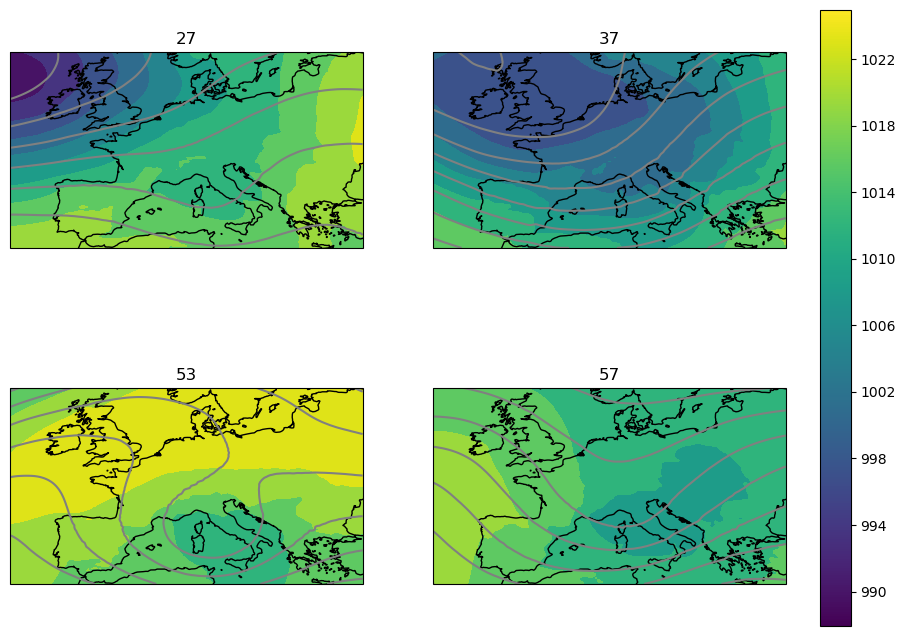

In [ ]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.ticker import FixedLocator


occurrences=Counter(cli)
print(occurrences[0])

# Initialize an empty array to store mean values

mean_node_MSL = np.zeros((4, dd4som.MSL.values.shape[1], dd4som.MSL.values.shape[2]))
mean_node_Z= np.zeros((4, dd4som.Z.values.shape[1], dd4som.Z.values.shape[2]))

unique=np.unique(cli)

mean_node_MSL = [np.mean(dd4som.MSL.values[cli == i,:,:],axis=0) for i in range(0,nn)]
mean_node_Z = [np.mean(dd4som.Z.values[cli == i,:,:],axis=0) for i in range(0,nn)]
std_node_MSL = [np.std(dd4som.MSL.values[cli == i,:,:],axis=0) for i in range(0,nn)]
std_node_Z = [np.std(dd4som.Z.values[cli == i,:,:],axis=0) for i in range(0,nn)]

# Create a Cartopy projection (PlateCarree for geographic data)
projection = ccrs.PlateCarree()

# Create map of mean node
fig, axs = plt.subplots(nx, ny, figsize=(11, 8), subplot_kw={'projection': projection})

# Calculate global min and max for d1/100
global_min_d1 = min([d.min() for d in mean_node_MSL])
global_max_d1 = max([d.max() for d in mean_node_MSL])

# Define levels for contour plot
levels_d1 = np.arange(np.round(global_min_d1-2), np.round(global_max_d1+2), 4)  # Replace min_value_d1, max_value_d1, step_d1 with actual values
#levels_d1 = np.linspace(np.round(global_min_d1-2), np.round(global_max_d1+2), 10)  # Replace min_value_d1, max_value_d1, step_d1 with actual values
print(levels_d1)

for ax, d1, d2, inode in zip(axs.flat, mean_node_MSL, mean_node_Z, range(0,nn)):
    # Plot the data using pcolormesh
    # cax1 = ax.contourf(dd4som['lon'].values, dd4som['lat'].values, d1/100, vmin=global_min_d1, vmax=global_max_d1, transform=projection)
    cax1 = ax.contourf(dd4som['lon'].values, dd4som['lat'].values, d1, levels_d1, transform=projection)

    cax2 = ax.contour(dd4som['lon'].values, dd4som['lat'].values, d2, colors='grey', transform=projection)

    # Add coastlines
    ax.coastlines()

    # add number of events
    ax.set_title(f"{occurrences[inode]}")

    # Add a colorbar
    #cbar = plt.colorbar(cax1,orientation='vertical', fraction=0.05, pad=0.04)

norm = Normalize(vmin=global_min_d1, vmax=global_max_d1)  # Adjust these values based on your data range
smappable = ScalarMappable(norm=norm, cmap=cax1.cmap)  # Use the colormap from your contour plot
cbar = fig.colorbar(smappable, ax=axs, orientation='vertical', fraction=0.05, pad=0.04, ticks=levels_d1)
#cbar.set_ticks(FixedLocator(levels_d1))  # Set ticks to match contour levels
plt.show()


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

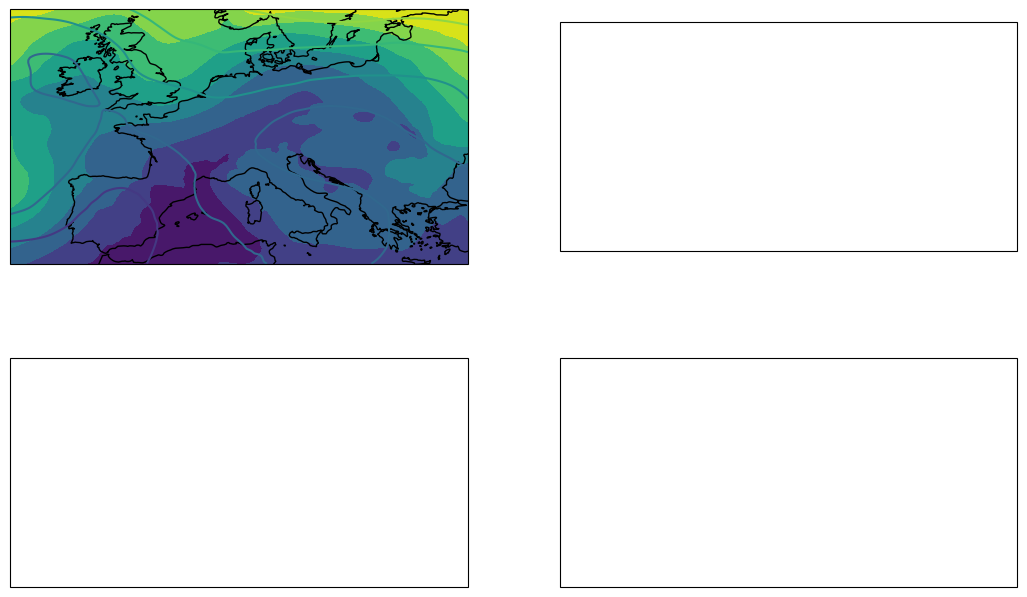

In [ ]:


# Create map of std within each node
fig, axs = plt.subplots(nx, ny, figsize=(13, 8), subplot_kw={'projection': projection})

for ax, d1, d2 in zip(axs.flat, std_node_MSL, std_node_Z):
    # Plot the data using pcolormesh
    cax1 = ax.contourf(dd4som['lon'].values, dd4som['lat'].values, d1/100, transform=projection)
    cax2 = ax.contour(dd4som['lon'].values, dd4som['lat'].values, d2, transform=projection)

    # Add coastlines
    ax.coastlines()


    # Create a single colorbar for the figure, using the ScalarMappable
    cbar = plt.colorbar(ax=cax1, orientation='vertical', fraction=0.05, pad=0.04)

    #cbar = plt.colorbar(cax1, orientation='vertical', fraction=0.05, pad=0.04)
plt.show()


(array([ 6574.,  8035.,  9496., 10957., 12418., 13879., 15340., 16801.,
        18262., 19723., 21184.]),
 [Text(6574.0, 0, '1988'),
  Text(8035.0, 0, '1992'),
  Text(9496.0, 0, '1996'),
  Text(10957.0, 0, '2000'),
  Text(12418.0, 0, '2004'),
  Text(13879.0, 0, '2008'),
  Text(15340.0, 0, '2012'),
  Text(16801.0, 0, '2016'),
  Text(18262.0, 0, '2020'),
  Text(19723.0, 0, '2024'),
  Text(21184.0, 0, '2028')])

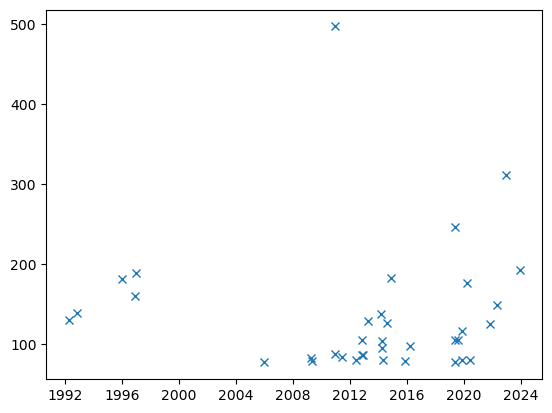

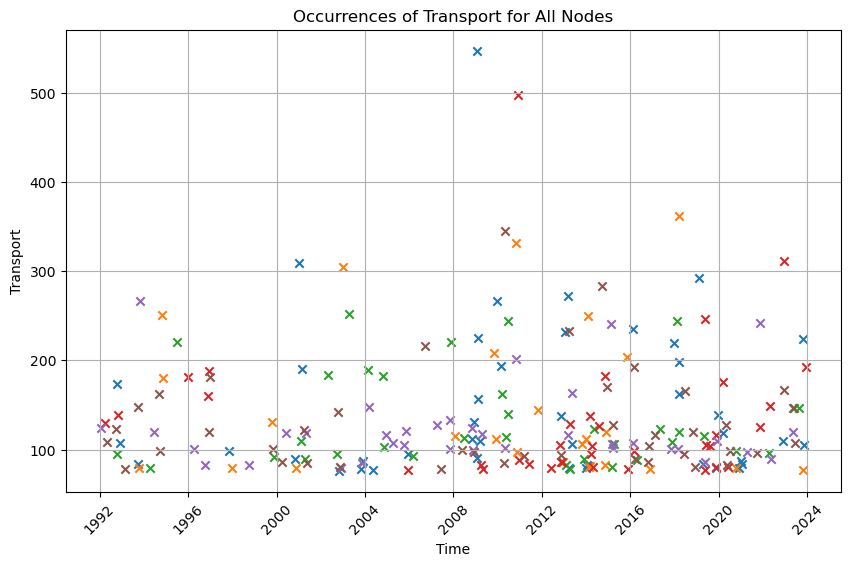

In [ ]:


all_transport_per_class = []
all_time_per_class = []

# Loop over each inode
for inode in range(nn):
    # Filter data for the current inode
    transport_per_class = df_events.loc[cli == inode, [0, 3]]
    time_per_class = dd4som.time[cli == inode]

    # Append the data to the respective lists
    all_transport_per_class.append(transport_per_class)
    all_time_per_class.append(time_per_class)



#plt.plot(all_time_per_class[3].time.values.T)
inode=3
plt.plot(all_time_per_class[inode],all_transport_per_class[inode][3],'x')



# Create a figure and axis for the plot
plt.figure(figsize=(10, 6))

# Iterate over all nodes
for inode in range(len(all_time_per_class)):
    # Extract the time and transport data for the current inode
    time_per_class = all_time_per_class[inode]
    transport_per_class = all_transport_per_class[inode]
    
    # Plot the occurrences for the current inode
    plt.scatter(time_per_class, transport_per_class[3], marker='x', label=f'Node {inode}')

# Add labels and title to the plot
plt.title('Occurrences of Transport for All Nodes')
plt.xlabel('Time')
plt.ylabel('Transport')
plt.grid(True)
plt.xticks(rotation=45)


2) Guardare stagionalità media portata, accadimento eventi
3) Fittare GEV to Annual maxima ... ma con 30 punti ci facciamo poco.... ELENA OK
4) Guardare dipendenza temporale eventi da posizione lungo corso d'acqua ---> massimo trasporto
5) Map tendency of annual maxima (Italy)
6) Composite centered-time evolution of event.
7) Pioggia su bacino idrografico / TCWV ---> OK, calcola tempo scala/lag dominante
8) Dati di stazione (esistono per panaro) 
10) Medie per stagione / o cluster alla grazzini su TCWV
11) Correlazione con fiumi limitrofi

-> distrubuzioni portate per cluster
-> Serie temporale cluster / portata media per cluster / trend portata per cluster 

-> realismo distribuzione portata forecasts
-> validare la stagionlità portata media
-> PDF aggregata per stagione
-> Distribuzione eventi che ti passano soglia / distribuzione massimi annuali

Correlazione spaziale piene spaziali di EFAS / composite o regressione usando o tutti i giorni o eventi di piena. Piene panaro sono associate a piene altri fiumi? Come cambia in funzione del regime?

